<a href="https://colab.research.google.com/github/lidorsandak/ad_ML_Competition_m5/blob/main/data_eda_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M5 Forecasting Challenge: Predicting Daily Walmart Revenue: EDA and Preprocessing

**Course:** Advanced Machine Learning - Final Assignment

---

In [2]:
# Cell 1: Setup and Data Loading
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# First, you might need to install Optuna
!pip install optuna -q

import optuna

# General imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random


from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.1 MB/s eta 0:00:00


In [4]:
# ########################### Vars################################################################################
# TARGET = 'sales'         # Our main target
# END_TRAIN = 1941         # Last day in train set
# MAIN_INDEX = ['id','d']  # We can identify item by these columns

Load Main Data

In [5]:
# Define path to your data on Google Drive
DATA_PATH = '/content/drive/MyDrive/M5_Project/'


train_df = pd.read_csv(DATA_PATH + 'train.csv')
calendar_df = pd.read_csv(DATA_PATH + 'calendar_events.csv')
sample_submission = pd.read_csv(DATA_PATH + 'forecast_submission.csv')

In [7]:
print('  unique forecasts: %i' % train_df.shape[0])
for col in train_df.columns:
  print('   N_unique %s: %i' % (col, train_df[col].nunique()))

train_df.head()


  unique forecasts: 18766
   N_unique store_id: 11
   N_unique store_name: 11
   N_unique date: 1706
   N_unique revenue: 18624


,store_id,store_name,date,revenue
0,0,All Stores,2011-01-29,204126.52
1,0,All Stores,2011-01-30,197426.42
2,0,All Stores,2011-01-31,144267.27
3,0,All Stores,2011-02-01,151903.00
4,0,All Stores,2011-02-02,117399.88


In [8]:

summary_by_store = train_df.groupby('store_id').agg(
    min_date=('date', 'min'),
    max_date=('date', 'max'),
    min_revenue=('revenue', 'min'),
    max_revenue=('revenue', 'max'),
    avg_revenue=('revenue', 'mean') # It's also useful to see the average
).reset_index()

# Improve formatting for readability
summary_by_store['min_revenue'] = summary_by_store['min_revenue'].round(2)
summary_by_store['max_revenue'] = summary_by_store['max_revenue'].round(2)
summary_by_store['avg_revenue'] = summary_by_store['avg_revenue'].round(2)

# Display the resulting table
print("Summary of Data Range and Revenue by Store ID:")
display(summary_by_store)

Summary of Data Range and Revenue by Store ID:


,store_id,min_date,max_date,min_revenue,max_revenue,avg_revenue
0,0,2011-01-29,2015-09-30,59.20,394304.00,237057.45
1,1,2011-01-29,2015-09-30,0.00,53079.07,28756.90
2,2,2011-01-29,2015-09-30,7.90,46946.10,21393.61
3,3,2011-01-29,2015-09-30,0.00,69466.55,41134.34
4,4,2011-01-29,2015-09-30,0.00,24894.20,15469.16
5,5,2011-01-29,2015-09-30,0.00,38790.60,20081.25
6,6,2011-01-29,2015-09-30,0.00,50754.12,26304.04
7,7,2011-01-29,2015-09-30,3.95,50970.07,22268.39
8,8,2011-01-29,2015-09-30,0.00,50715.82,18289.56
9,9,2011-01-29,2015-09-30,0.00,43798.95,21709.92


In [9]:
# The submission file ID is store_id + date (YYYYMMDD)
# We need to parse the date part of the 'id' string.
submission_ids = sample_submission['id'].str.split('_', expand=True)
submission_ids.columns = ['store_id_str', 'date_str']

# Convert the date string to a proper datetime object
submission_dates = pd.to_datetime(submission_ids['date_str'], format='%Y%m%d')

# Now find the min and max dates
min_submission_date = submission_dates.min()
max_submission_date = submission_dates.max()

# Calculate the duration (our forecast horizon H)
num_forecast_days = (max_submission_date - min_submission_date).days + 1

print(f"Submission File Analysis:")
print(f"-------------------------")
print(f"Forecast Start Date: {min_submission_date.date()}")
print(f"Forecast End Date:   {max_submission_date.date()}")
print(f"Total Forecast Horizon (H): {num_forecast_days} days")

Submission File Analysis:
-------------------------
Forecast Start Date: 2015-10-01
Forecast End Date:   2015-12-31
Total Forecast Horizon (H): 92 days


##### **Data Merging and Preparation**

In [10]:
# Convert 'date' columns to datetime objects
train_df['date'] = pd.to_datetime(train_df['date'])
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

# Merge train_df with calendar_df to get all features in one place
original_df = pd.merge(train_df, calendar_df, on='date', how='left')
original_df['event'].fillna('NoEvent', inplace=True)

print("\nData merged:")
original_df.head()



Data merged:


,store_id,store_name,date,revenue,event
0,0,All Stores,2011-01-29,204126.52,NoEvent
1,0,All Stores,2011-01-30,197426.42,NoEvent
2,0,All Stores,2011-01-31,144267.27,NoEvent
3,0,All Stores,2011-02-01,151903.00,NoEvent
4,0,All Stores,2011-02-02,117399.88,NoEvent


## EDA

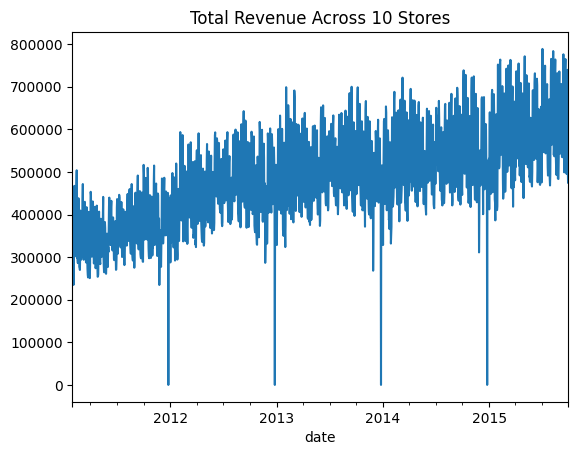

Text(0.5, 1.0, 'Revenue by Day of the Week')

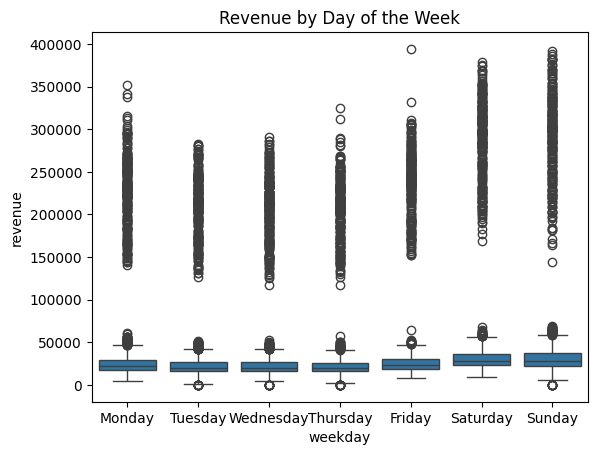

In [11]:
# --- 4. Exploratory Data Analysis (EDA) ---

# Plot 1: Aggregate Revenue (across the 10 real stores)
original_df.groupby('date')['revenue'].sum().plot(title='Total Revenue Across 10 Stores')
plt.show()

# Plot 2: Weekly Seasonality
# Before plotting, let's get the weekday name from the date
original_df['weekday'] = original_df['date'].dt.day_name()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.boxplot(data=original_df, x='weekday', y='revenue', order=day_order)
plt.title('Revenue by Day of the Week')

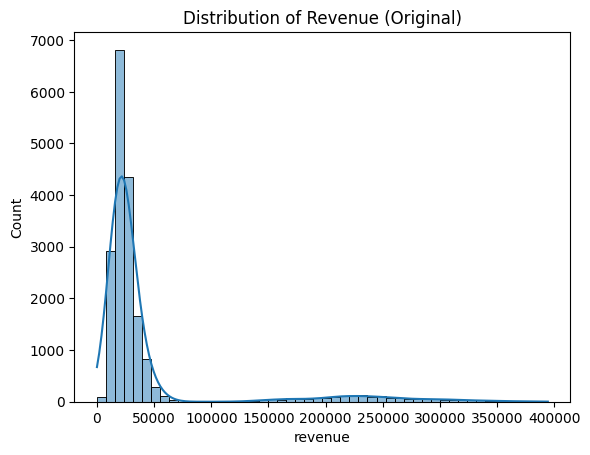

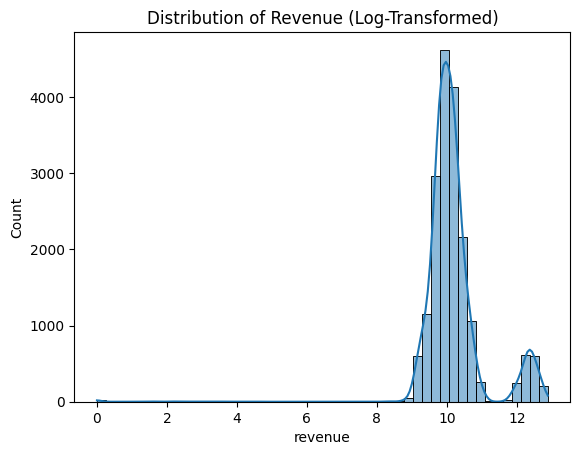

In [13]:
# Let's visualize the revenue distribution
sns.histplot(original_df['revenue'], kde=True, bins=50)
plt.title('Distribution of Revenue (Original)')
plt.show()

# Now apply log1p and visualize again
sns.histplot(np.log1p(original_df['revenue']), kde=True, bins=50)
plt.title('Distribution of Revenue (Log-Transformed)')
plt.show()

3. Feature Engineering



In [14]:
def create_features(data):
    """
    Creates time series features from a datetime index.
    """
    # Make a copy to avoid modifying the original dataframe
    new_df = data.copy()

    # --- 1. Date-based Features ---
    # These help the model learn seasonal patterns
    new_df['date'] = pd.to_datetime(new_df['date'])
    new_df['day_of_week'] = new_df['date'].dt.dayofweek  # Monday=0, Sunday=6
    new_df['day_of_month'] = new_df['date'].dt.day
    new_df['week_of_year'] = new_df['date'].dt.isocalendar().week.astype(int)
    new_df['month'] = new_df['date'].dt.month
    new_df['year'] = new_df['date'].dt.year
    new_df['is_weekend'] = (new_df['day_of_week'] >= 5).astype(int) # 1 for weekend, 0 for weekday

    # --- 2. Lag Features ---
    # These are the most powerful features. They tell the model what the revenue was in the recent past.
    # We must create lags based on our forecast horizon, H. The smallest lag must be >= H.
    # Let's assume H was 28 (replace with the actual H you found if different)
    h_forecast = H
    lags = [h_forecast, h_forecast + 1, h_forecast + 7, h_forecast + 14, h_forecast + 28]

    # Sort data to ensure lags are correct
    new_df = new_df.sort_values(['store_id', 'date'])

    for lag in lags:
        new_df[f'revenue_lag_{lag}'] = new_df.groupby('store_id')['revenue'].shift(lag)

    # --- 3. Rolling Window Features ---
    # These capture recent trends and momentum.
    # We use a window that starts after the lag period.
    window_sizes = [7, 14, 28]
    for window in window_sizes:
        # The shift of h_forecast is crucial to prevent data leakage
        rolling_series = new_df.groupby('store_id')['revenue'].shift(h_forecast).rolling(window)
        new_df[f'revenue_roll_mean_{window}'] = rolling_series.mean()
        new_df[f'revenue_roll_std_{window}'] = rolling_series.std()

    # --- 4. Event Features ---
    # Convert text-based events into a format the model can use.
    # We will use one-hot encoding later, but for now we can make it a categorical type.
    new_df['event'] = new_df['event'].astype('category')

    # Convert store_id to category as well, so the model treats it as a label, not a number.
    new_df['store_id'] = new_df['store_id'].astype('category')

    return new_df

In [16]:
# --- Apply the feature engineering function ---
# First, apply log-transform to the revenue
original_df['revenue'] = np.log1p(original_df['revenue'])

# Now generate all features on the full transformed dataset
df_featured = create_features(original_df)

# IMPORTANT: Drop rows with NaN values created by lags and rolling windows
df_featured.dropna(inplace=True)

# --- Re-create train and validation sets from the FEATURED data ---
last_train_date_featured = df_featured['date'].max() - pd.to_timedelta(H, unit='D')
validation_start_date_featured = last_train_date_featured + pd.to_timedelta(1, unit='D')

train_final = df_featured[df_featured['date'] <= last_train_date_featured]
val_final = df_featured[df_featured['date'] >= validation_start_date_featured]

# --- Define our features (X) and target (y) ---
# The target is the original 'revenue' column (which is now log-transformed)
TARGET = 'revenue'

# Features are all columns except the target and identifiers that leak info
# We exclude 'store_name' and the original 'date' column
FEATURES = [col for col in train_final.columns if col not in [TARGET, 'store_name', 'date', 'weekday']]
# 'weekday' is excluded because we already have 'day_of_week' numeric feature

X_train = train_final[FEATURES]
y_train = train_final[TARGET]

X_val = val_final[FEATURES]
y_val = val_final[TARGET]

# Check the shapes to ensure everything is correct
print("Training data shape (X, y):", X_train.shape, y_train.shape)
print("Validation data shape (X, y):", X_val.shape, y_val.shape)
print("\nHere are a few of the features we created:")
print(X_train.head())

NameError: name 'H' is not defined